# Database Ingestion Workbook

**Real-world workflow**: Ingest CSV data into HLLSet-based semantic database

## Overview

This workbook demonstrates columnar database ingestion:
1. Convert CSV files → DuckDB (one-time)
2. Ingest database column-by-column into HLLSets
3. Create data + metadata hierarchies with explicit entanglement
4. Query and analyze ingested data semantically

## Architecture

```
CSV Files → DuckDB → Columnar Ingestion → HLLSet Hierarchy
                      ├─ Data: DB → Tables → Columns
                      ├─ Metadata: Raw + Fingerprints + SHA1 IDs
                      └─ Entanglement: Data ↔ Metadata
```

**Key Benefit**: Thousands of columns vs millions/billions of rows = massive compression

## Step 1: Initialize System

In [1]:
# Import required modules
from pathlib import Path
import json
from core.manifold_os import ManifoldOS
from core.db_ingestion import DatabaseIngestionSystem
from tools.db_query_helper import DatabaseQueryHelper

# Initialize ManifoldOS with unified storage
manifold = ManifoldOS()
print(f"✓ ManifoldOS initialized")
print(f"  Storage: {manifold.store.storage_path}")

✓ Extension registered: storage v1.4.4
✓ Extension registered: storage v1.4.4
✓ ManifoldOS initialized
  Storage: .manifold_storage


## Step 2: CSV to DuckDB Conversion

**One-time operation**: Convert directory of CSV files into single DuckDB database.

### Instructions:

1. Update `csv_directory` path below to point to your CSV files
2. Run the conversion cell (uncomment first)
3. Verify the database was created

**Note**: This creates a persistent DuckDB file. Only run once, or when you want to refresh the data.

In [2]:
# Configure paths
csv_directory = "/home/alexmy/Downloads/POC/demo/pub/finance/"  # UPDATE THIS!
db_path = Path("./data/finance_data.duckdb")  # Use different name to avoid conflicts

print(f"CSV directory: {csv_directory}")
print(f"Database path: {db_path}")
print()
print("To convert CSVs to DuckDB, uncomment and run:")
print(f"  !python tools/csv2db.py {csv_directory} {db_path}")

CSV directory: /home/alexmy/Downloads/POC/demo/pub/finance/
Database path: data/finance_data.duckdb

To convert CSVs to DuckDB, uncomment and run:
  !python tools/csv2db.py /home/alexmy/Downloads/POC/demo/pub/finance/ data/finance_data.duckdb


In [3]:
# Uncomment the line below and run to perform conversion:
# !python tools/csv2db.py {csv_directory} {db_path}

# Verify database exists
if db_path.exists():
    size_mb = db_path.stat().st_size / 1024 / 1024
    print(f"✓ Database found: {db_path}")
    print(f"  Size: {size_mb:.2f} MB")
else:
    print(f"✗ Database not found: {db_path}")
    print("  Run the conversion command above first")

✓ Database found: data/finance_data.duckdb
  Size: 4.01 MB


### Explore Database (Optional)

Quick peek at what's in the database:

In [4]:
# Explore database contents
if db_path.exists():
    import duckdb
    
    try:
        conn = duckdb.connect(str(db_path), read_only=True)
        
        # List tables
        tables = conn.execute("""
            SELECT table_name, 
                   (SELECT COUNT(*) FROM duckdb_columns() c 
                    WHERE c.table_name = t.table_name) as column_count
            FROM duckdb_tables() t
            WHERE schema_name = 'main'
            ORDER BY table_name
        """).fetchall()
        
        print(f"Database contains {len(tables)} tables:\n")
        for table_name, col_count in tables[:20]:  # Show first 20
            print(f"  • {table_name:40s} ({col_count:2d} columns)")
        
        if len(tables) > 20:
            print(f"  ... and {len(tables) - 20} more tables")
        
        conn.close()
    except Exception as e:
        print(f"⚠ Could not explore database: {e}")
        print("\nThis is usually because the database is already open.")
        print("Solution: Use a different database filename (see cell above)")
        print("or skip this exploration cell and continue with ingestion.")
else:
    print("Database not found - skip this cell")

Database contains 6 tables:

  • fdic_failed_banklist                     ( 7 columns)
  • investment_company_series_class          (20 columns)
  • nfl_offensive_player_stats_1999_2013     (26 columns)
  • public_company_bankruptcy_cases          ( 5 columns)
  • subprime_2006_distributed                ( 5 columns)
  • top_teams_payroll                        ( 9 columns)


## Step 3: Columnar Ingestion

Now ingest the database column by column into HLLSets.

### What happens:
- Each column → HLLSet (all distinct values)
- Each table → HLLSet (union of columns)
- Database → HLLSet (union of tables)
- Metadata hierarchy (raw + fingerprints + SHA1 IDs)
- Explicit entanglements (data ↔ metadata)

**Time estimate**: ~5-15 minutes for 200 tables

In [5]:
# Initialize ingestion system
db_ingestion = DatabaseIngestionSystem(manifold)
print("✓ Ingestion system initialized")

✓ Ingestion system initialized


In [6]:
# Perform columnar ingestion
if db_path.exists():
    print("Starting columnar ingestion...\n")
    ingestion_result = db_ingestion.ingest_database(db_path)
    
    # Save result for later use
    result_path = Path('./data/ingestion_result.json')
    with open(result_path, 'w') as f:
        json.dump(ingestion_result, f, indent=2)
    
    print(f"\n✓ Ingestion complete!")
    print(f"  Result saved to: {result_path}")
    print(f"  Database HLLSet ID: {ingestion_result['database']['data_id']}")
    print(f"  Tables ingested: {len(ingestion_result['tables'])}")
else:
    print("Database not found - cannot ingest")
    ingestion_result = None

Starting columnar ingestion...

COLUMNAR DATABASE INGESTION
Connected to database: data/finance_data.duckdb

Database: main
Tables: 6

Ingesting table: fdic_failed_banklist
  Columns: 7, Rows: 540
    Processing column: Bank_Name... ✓ (527.093271641218 distinct values)
    Processing column: City... ✓ (420.7110943137351 distinct values)
    Processing column: ST... ✓ (44.97329554927163 distinct values)
    Processing column: CERT... ✓ (550.7901968883931 distinct values)
    Processing column: Acquiring_Institution... ✓ (286.61753037795944 distinct values)
    Processing column: Closing_Date... ✓ (230.00009625262697 distinct values)
    Processing column: Updated_Date... ✓ (101.9066777944042 distinct values)

Ingesting table: investment_company_series_class
  Columns: 20, Rows: 41,283
    Processing column: Reporting File Number... ✓ (2445.493271889356 distinct values)
    Processing column: CIK Number... ✓ (2501.463486328129 distinct values)
    Processing column: Name of Investment Co

## Step 4: Initialize Query Helper

Load the ingestion result and create query helper for semantic search.

In [7]:
# Load ingestion result (if not already in memory)
result_path = Path('./data/ingestion_result.json')

if result_path.exists():
    if 'ingestion_result' not in locals() or ingestion_result is None:
        with open(result_path, 'r') as f:
            ingestion_result = json.load(f)
    
    # Initialize query helper with database path for sample queries
    helper = DatabaseQueryHelper(manifold, str(result_path), db_path=str(db_path))
    
    print("✓ Query helper initialized")
    print()
    helper.print_database_summary()
else:
    print("Ingestion result not found - run ingestion first")
    helper = None

✓ Query helper initialized

DATABASE SUMMARY
Database HLLSet cardinality: 126,619.03963744226
Number of tables: 6
Total columns: 72

Tables:
  • fdic_failed_banklist           (  7 columns)
  • investment_company_series_class ( 20 columns)
  • nfl_offensive_player_stats_1999_2013 ( 26 columns)
  • public_company_bankruptcy_cases (  5 columns)
  • subprime_2006_distributed      (  5 columns)
  • top_teams_payroll              (  9 columns)


## Step 5: Semantic Column Search

Search for columns by semantic similarity, not just name matching.

In [8]:
# Example: Search for revenue/sales-related columns
if helper:
    search_keywords = ["revenue", "sales", "income", "amount", "total"]
    
    print(f"Searching for columns related to: {search_keywords}\n")
    
    matches = helper.search_columns(search_keywords, threshold=0.1)
    
    print(f"Found {len(matches)} matches:\n")
    print("-" * 80)
    
    for match in matches[:15]:  # Show top 15
        print(f"{match['similarity']:.3f} | {match['table']:30s} | {match['column']:25s}")
        print(f"       Type: {match['data_type']:15s} | Distinct: {match['distinct_count']:>10,}")
        print()
    
    if len(matches) > 15:
        print(f"... and {len(matches) - 15} more matches")
else:
    print("Helper not initialized")

Searching for columns related to: ['revenue', 'sales', 'income', 'amount', 'total']

Found 0 matches:

--------------------------------------------------------------------------------


### Try Your Own Search

Modify the keywords below to search for different columns:

In [9]:
# Custom search - modify these keywords
if helper:
    custom_keywords = ["customer", "name", "email"]  # UPDATE THIS
    
    matches = helper.search_columns(custom_keywords, threshold=0.1)
    
    print(f"Searching: {custom_keywords}")
    print(f"Found {len(matches)} matches:\n")
    
    for match in matches[:10]:
        print(f"{match['similarity']:.3f} | {match['table']:25s}.{match['column']:20s}")
        print(f"       {match['data_type']}")
        print()

Searching: ['customer', 'name', 'email']
Found 0 matches:



## Step 6: Explore Table and Column Details

In [10]:
# Get information about a specific table
if helper:
    # List available tables
    tables = helper.list_tables()
    print(f"Available tables ({len(tables)}):")
    for i, table in enumerate(tables[:20], 1):
        print(f"  {i:3d}. {table}")
    
    if len(tables) > 20:
        print(f"  ... and {len(tables) - 20} more")

Available tables (6):
    1. fdic_failed_banklist
    2. investment_company_series_class
    3. nfl_offensive_player_stats_1999_2013
    4. public_company_bankruptcy_cases
    5. subprime_2006_distributed
    6. top_teams_payroll


In [11]:
# Explore a specific table (update table name)
if helper:
    table_name = helper.list_tables()[0]  # First table, or specify name
    
    info = helper.get_table_info(table_name)
    
    print(f"Table: {info['name']}")
    print(f"Rows: {info['metadata']['row_count']:,}")
    print(f"\nColumns ({len(info['columns'])}):\n")
    
    for col in info['columns']:
        col_info = helper.get_column_info(table_name, col)
        meta = col_info['metadata']
        print(f"  • {col:30s} | {meta['data_type']:15s} | {col_info['cardinality']:>8,} distinct")

Table: fdic_failed_banklist
Rows: 540

Columns (7):

  • Bank_Name                      | VARCHAR         | 527.093271641218 distinct
  • City                           | VARCHAR         | 420.7110943137351 distinct
  • ST                             | VARCHAR         | 44.97329554927163 distinct
  • CERT                           | BIGINT          | 550.7901968883931 distinct
  • Acquiring_Institution          | VARCHAR         | 286.61753037795944 distinct
  • Closing_Date                   | VARCHAR         | 230.00009625262697 distinct
  • Updated_Date                   | VARCHAR         | 101.9066777944042 distinct


## Step 7: Sample Data Retrieval

Get sample values from columns via disambiguation:

In [12]:
# Get sample values from a column
if helper:
    table_name = helper.list_tables()[0]  # Or specify
    column_name = helper.get_table_info(table_name)['columns'][0]  # Or specify
    
    print(f"Sample values from {table_name}.{column_name}:\n")
    
    samples = helper.get_column_sample_values(table_name, column_name, limit=10)
    
    for i, value in enumerate(samples, 1):
        print(f"  {i:2d}. {value}")

Sample values from fdic_failed_banklist.Bank_Name:

   1. The Community's Bank
   2. First Community Bank of Southwest Florida (also operating as Community Bank of Cape Coral)
   3. Parkway Bank
   4. Covenant Bank
   5. Hometown Community Bank
   6. First East Side Savings Bank
   7. Second Federal Savings and Loan Association of Chicago
   8. Security Bank, National Association
   9. HarVest Bank of Maryland
  10. Central Bank of Georgia


## Step 8: Foreign Key Detection

Find potential foreign key relationships by comparing column HLLSets:

In [13]:
# Find columns related to a specific column (potential FKs)
if helper:
    # Look for ID columns that might have FK relationships
    id_columns = []
    for table_name in helper.list_tables()[:10]:  # Check first 10 tables
        table_info = helper.get_table_info(table_name)
        for col in table_info['columns']:
            if 'id' in col.lower():
                id_columns.append((table_name, col))
    
    print(f"Found {len(id_columns)} ID columns\n")
    
    if id_columns:
        # Analyze first ID column
        table_name, column_name = id_columns[0]
        
        print(f"Analyzing relationships for: {table_name}.{column_name}\n")
        print("-" * 70)
        
        related = helper.find_related_columns(table_name, column_name, threshold=0.5)
        
        if related:
            print(f"Found {len(related)} potential relationships:\n")
            for rel in related[:10]:
                print(f"{rel['similarity']:.3f} | {rel['table']:25s}.{rel['column']:20s}")
                print(f"       Overlap: {rel['overlap_cardinality']:,} values")
                print()
        else:
            print("No strong relationships found (try lower threshold)")

Found 5 ID columns

Analyzing relationships for: investment_company_series_class.Series ID

----------------------------------------------------------------------
No strong relationships found (try lower threshold)


## Step 9: Cross-Table Analysis

Compare data patterns across tables:

In [14]:
# Find duplicate data across tables
if helper and ingestion_result:
    from core.hllset import HLLSet
    
    # Example: Look for email columns across tables
    email_columns = []
    
    for table_name, table_data in list(ingestion_result['tables'].items())[:20]:
        for col_name in table_data['columns'].keys():
            if 'email' in col_name.lower() or 'mail' in col_name.lower():
                email_columns.append((table_name, col_name, table_data['columns'][col_name]))
    
    if len(email_columns) >= 2:
        print(f"Found {len(email_columns)} email-related columns:\n")
        
        for table, col, _ in email_columns:
            print(f"  • {table}.{col}")
        
        # Compare first two
        if len(email_columns) >= 2:
            t1, c1, d1 = email_columns[0]
            t2, c2, d2 = email_columns[1]
            
            # Load HLLSets
            hll1 = HLLSet.from_roaring(manifold.retrieve_artifact(d1['data_id']))
            hll2 = HLLSet.from_roaring(manifold.retrieve_artifact(d2['data_id']))
            
            # Calculate overlap
            intersection = hll1.intersect(hll2)
            union = hll1.union(hll2)
            
            print(f"\nComparing {t1}.{c1} vs {t2}.{c2}:")
            print(f"  • {t1}.{c1}: {hll1.cardinality():,} unique values")
            print(f"  • {t2}.{c2}: {hll2.cardinality():,} unique values")
            print(f"  • Overlap: {intersection.cardinality():,} values")
            print(f"  • Jaccard similarity: {intersection.cardinality() / union.cardinality():.3f}")
    else:
        print("Not enough email columns found for comparison")

Not enough email columns found for comparison


### Export Graph

Save the graph in multiple formats for external analysis tools.

### Visualize Database Graph

**Warning**: Large databases may take time to render. Consider visualizing subgraphs.

In [15]:
# Build graph from database hierarchy
if helper and ingestion_result:
    from core.graph_visualizer import (
        LatticeGraphBuilder,
        LatticeVisualizer,
        test_consistency
    )
    
    print("Building property graph from database hierarchy...")
    
    builder = LatticeGraphBuilder()
    builder.from_database_hierarchy(ingestion_result, manifold)
    
    # Test consistency
    consistency = test_consistency(builder)
    print(f"\nConsistency check: {'✓ PASSED' if consistency['passed'] else '✗ FAILED'}")
    
    if consistency['errors']:
        print(f"Errors: {len(consistency['errors'])}")
        for error in consistency['errors'][:5]:
            print(f"  - {error}")
    
    if consistency['warnings']:
        print(f"Warnings: {len(consistency['warnings'])}")
    
    # Get statistics
    viz = LatticeVisualizer(builder)
    viz.print_statistics()
    
    # Detect foreign keys
    fk_count = builder.detect_potential_foreign_keys(threshold=0.7)
    print(f"\n✓ Detected {fk_count} potential foreign key relationships")
else:
    print("No ingestion result - skip visualization")
    builder = None
    viz = None

Building property graph from database hierarchy...

Consistency check: ✓ PASSED
LATTICE GRAPH STATISTICS
Nodes: 79
Edges: 78
Density: 0.0127
Weakly connected: True

Degree statistics:
  Average: 1.97
  Min: 1
  Max: 27

Node types:
  column              :   72
  database            :    1
  table               :    6

Edge types:
  contains            :   78

✓ Detected 1 potential foreign key relationships


Visualizing full graph (79 nodes)...


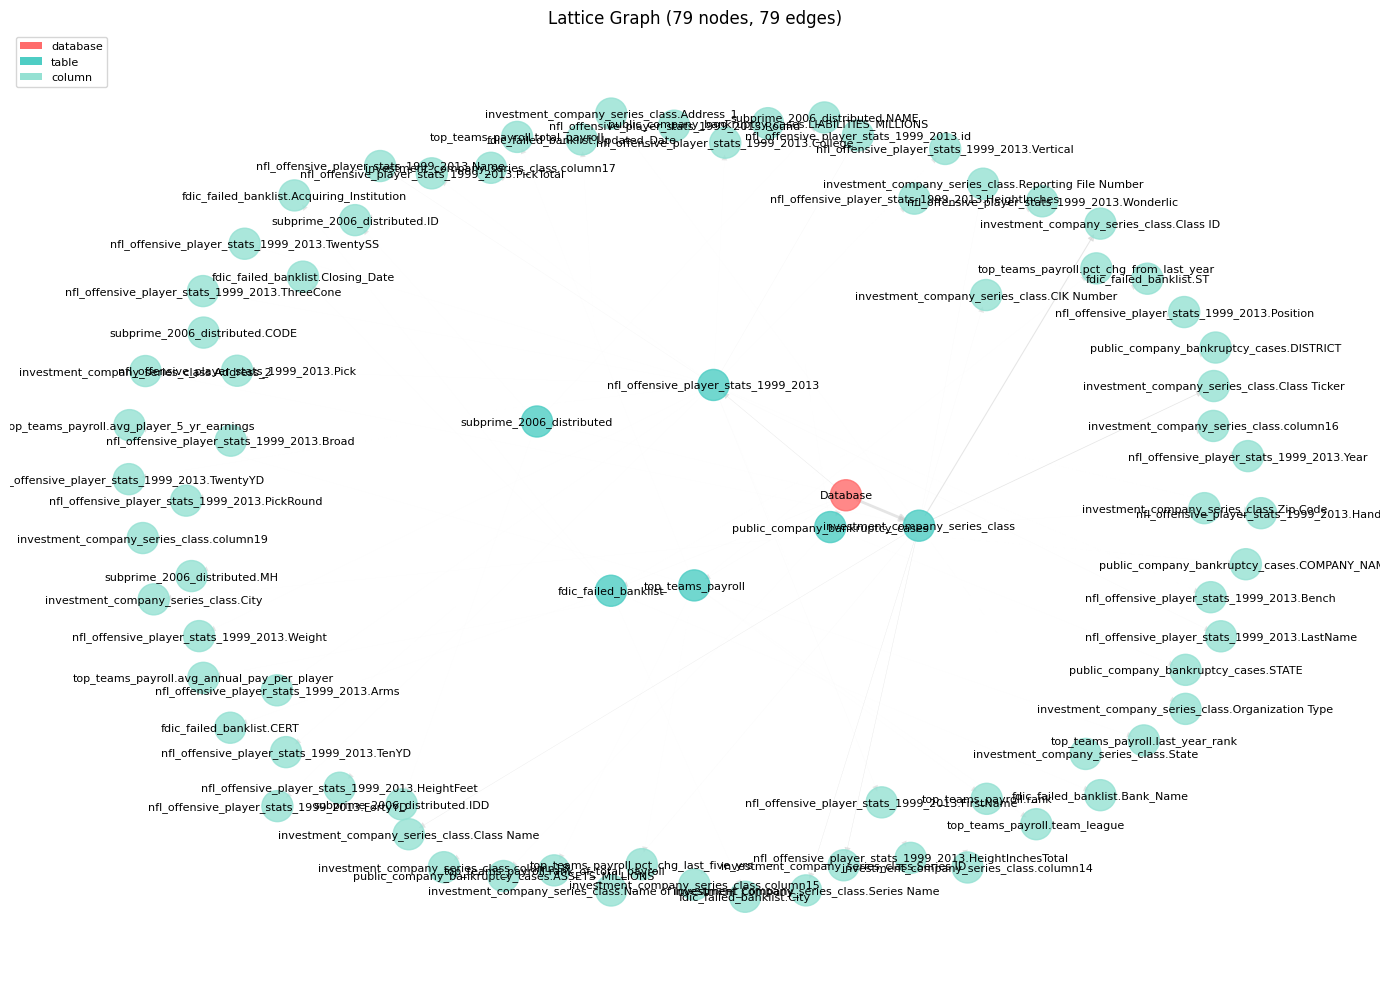

In [16]:
# Visualize database structure
if viz:
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    node_count = builder.graph.number_of_nodes()
    
    if node_count > 100:
        print(f"Graph has {node_count} nodes - showing subgraph instead...")
        
        # Get first table and visualize its neighborhood
        table_nodes = [nid for nid, meta in builder.nodes.items() if meta.node_type == 'table']
        if table_nodes:
            first_table = table_nodes[0]
            print(f"Showing subgraph around: {builder.nodes[first_table].label}")
            
            viz.plot_subgraph(
                node_ids=[first_table],
                depth=2,
                figsize=(14, 10),
                layout='spring',
                show_labels=True
            )
    else:
        print(f"Visualizing full graph ({node_count} nodes)...")
        viz.plot(
            figsize=(14, 10),
            layout='spring',
            show_labels=True
        )
else:
    print("No graph to visualize")

## Step 11: Visualize Database Structure

Use graph visualization to see the database hierarchy as a property graph.

## Step 10: Query Planning

Use HLLSet cardinality to estimate query selectivity:

In [17]:
# Estimate query result size
if helper and ingestion_result:
    from core.hllset import HLLSet
    
    # Example: Estimate "WHERE column IN (values)" selectivity
    table_name = helper.list_tables()[0]
    table_info = helper.get_table_info(table_name)
    column_name = table_info['columns'][0]
    
    # Get column HLLSet
    col_data = ingestion_result['tables'][table_name]['columns'][column_name]
    col_hllset = HLLSet.from_roaring(manifold.retrieve_artifact(col_data['data_id']))
    
    # Create query HLLSet (simulate WHERE clause)
    # Get some sample values to use as query filter
    sample_values = helper.get_column_sample_values(table_name, column_name, limit=5)
    query_hllset = HLLSet.from_batch(sample_values[:3])  # Use 3 values
    
    # Estimate selectivity
    matching = col_hllset.intersect(query_hllset)
    selectivity = matching.cardinality() / col_hllset.cardinality()
    estimated_rows = int(table_info['metadata']['row_count'] * selectivity)
    
    print(f"Query estimation for: {table_name}.{column_name}")
    print(f"\nQuery filter: WHERE {column_name} IN {sample_values[:3]}")
    print(f"\nEstimates:")
    print(f"  • Table rows: {table_info['metadata']['row_count']:,}")
    print(f"  • Distinct values in column: {col_hllset.cardinality():,}")
    print(f"  • Matching values: {matching.cardinality():,}")
    print(f"  • Selectivity: {selectivity:.3%}")
    print(f"  • Estimated result rows: {estimated_rows:,}")

Query estimation for: fdic_failed_banklist.Bank_Name

Query filter: WHERE Bank_Name IN ['The National Republic Bank of Chicago', 'Eastside Commercial Bank', 'Heritage Bank of Florida']

Estimates:
  • Table rows: 540
  • Distinct values in column: 527.093271641218
  • Matching values: 0.0
  • Selectivity: 0.000%
  • Estimated result rows: 0


## Summary

You've successfully:

✅ Converted CSV files → DuckDB  
✅ Ingested database column-by-column into HLLSets  
✅ Created data + metadata hierarchies  
✅ Performed semantic column search  
✅ Detected foreign key relationships  
✅ Analyzed cross-table patterns  
✅ Estimated query selectivity  

## Next Steps

- **Natural Language → SQL**: Use column search to help generate SQL queries
- **Data Quality**: Find duplicate/inconsistent data across tables
- **Schema Evolution**: Track changes over time
- **Privacy**: Data stored as HLLSets, requires disambiguation to access

## Resources

- [DOCS/COLUMNAR_INGESTION.md](DOCS/COLUMNAR_INGESTION.md) - Full architecture
- [tools/README_CSV2DB.md](tools/README_CSV2DB.md) - CSV converter details
- [QUICKSTART_COLUMNAR.md](QUICKSTART_COLUMNAR.md) - Quick reference